In [17]:
import pypsa
import matplotlib.pyplot as plt
import pandas as pd
import myUtils as utils

rootPath = "../../results/scenario/warm"
pathTail = "/networks/base_s_27_3H_3H_2045.nc"

%load_ext autoreload
%autoreload 2


plt.style.use('bmh')
%matplotlib inline

nBase = pypsa.Network(f"../../results/scenario/base{pathTail}")
nMean = pypsa.Network(f"{rootPath}_mean/{pathTail}")
nGood = pypsa.Network(f"{rootPath}_good/{pathTail}")
nBest = pypsa.Network(f"{rootPath}_best/{pathTail}")

networks = {
  "Sehr Optimistisch": nBest,
  "Optimistisch": nGood,
  "Mittel": nMean,
  # "Basis": nBase,
}

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


INFO:pypsa.io:Imported network base_s_27_3H_3H_2045.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_27_3H_3H_2045.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_27_3H_3H_2045.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_27_3H_3H_2045.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


                   Wärmepumpe     DAC  Widerstandsheizung
Sehr Optimistisch    48.87316 0.28822            41.38777
Optimistisch         39.82575 0.00004            43.02294
Mittel               37.07630 0.30980            43.64877


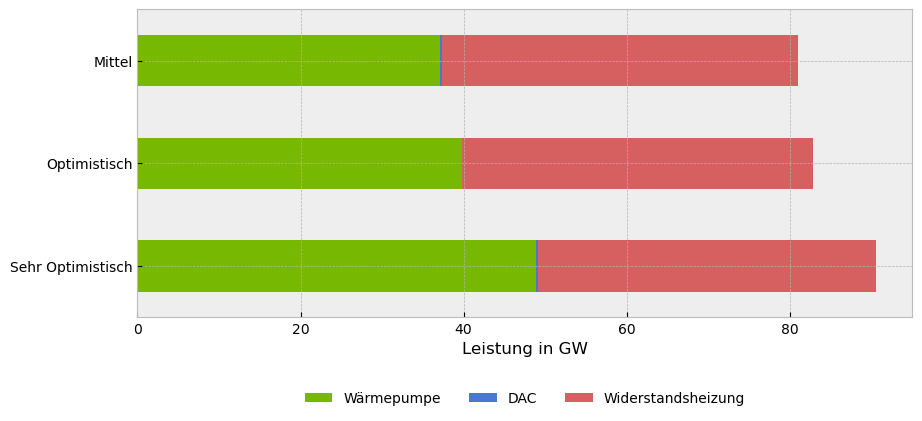

In [30]:
import pandas as pd
import myUtils as utils
import importlib
importlib.reload(utils)

import seaborn as sns
plt.style.use('seaborn-v0_8-muted')
sns.color_palette("muted")

dfP = pd.DataFrame()
dfPrice = pd.DataFrame()

for key, n in networks.items():
  sp = pd.Series()
  sprice =  pd.Series()

  warm = utils.getNByGroup(n,'Link', utils.de_warm_link)
  p0 = warm.groupby('carrier')['p_nom_opt'].sum() / 1e3
  price = warm.groupby('carrier')['capital_cost'].sum() / 1e6
  
  sp['Wärmepumpe'] = p0['rural air heat pump'] + p0['rural ground heat pump'] + p0['urban central air heat pump'] + p0['urban decentral air heat pump']
  sp['Widerstandsheizung'] =p0['urban central resistive heater'] + p0['rural resistive heater'] + p0['urban decentral resistive heater']
  sp['DAC'] = p0['DAC']
  
  sprice['Wärmepumpe'] =  price['rural air heat pump'] + price['rural ground heat pump'] + price['urban central air heat pump'] + price['urban decentral air heat pump']
  sprice['DAC'] = price['DAC']
  sprice['Widerstandsheizung'] =price['urban central resistive heater'] + price['rural resistive heater'] + price['urban decentral resistive heater']

  sp.reindex(['Wärmepumpe', 'Widerstandsheizung', 'DAC'])
  sprice.reindex(['Wärmepumpe', 'Widerstandsheizung', 'DAC'])

  dfP[key] = sp
  dfPrice[key] = sprice
    


dfP = dfP.transpose()
dfP = dfP[['Wärmepumpe', 'DAC', 'Widerstandsheizung']]

new_order = ['Basis', 'Mittel', 'Optimistisch', 'Sehr Optimistisch']
dfP.reindex(new_order)
dfPrice.reindex(new_order)

dfPrice = dfPrice.transpose()

colorP={
  'Wärmepumpe': '#76B802',
  'Widerstandsheizung': '#D65F5F',
  'DAC': '#4878D0'
}

colorPrice={
  'Wärmepumpe': '#D3E8B0',
  'Widerstandsheizung': '#E5C6C6',
  'DAC': '#97AED9'
}

# fig, ax1 = plt.subplots()



bars1= dfP.plot(kind='barh',    stacked=True, color=colorP, figsize=(10,4))

# ax2 = ax1.twiny()
# dfPrice.plot(kind='barh',  ax=ax2, position=1, width=0.3, label='Dataset 2', stacked=True, color= colorPrice, figsize=(10,4))

bars1.set_xlabel('Leistung in GW')
# ax1.set_xlabel('CAPEX in Mio.EUR')

bars1.legend(loc='upper center', ncol=3, frameon=False, bbox_to_anchor=(0.5, -0.2))
# ax2.legend(loc='lower center',ncol=3, frameon=False, bbox_to_anchor=(0.5, -0.3))




print(dfP)

In [16]:
from pea import Pea, carriers as cs


df = pd.DataFrame()
for key, n in networks.items():
  pea = Pea(n, config={'resolution': 3})
  s = pd.Series()
  s['Wassertank CAPEX'] = pea.get(cs.tank).capex() / 1e6
  s['Wärmepumpe CAPEX'] = pea.get(cs.heatPump).capex() / 1e6
  s['DAC CAPEX'] = pea.get(cs.dac).capex() / 1e6
  s['resistiveHeat CAPEX'] = pea.get(cs.resistiveHeat).capex() / 1e6


  s['Wassertankkapazität'] = pea.get(cs.tank).e_nom_opt() / 1e6

  s['Wassertankleistung'] = pea.get(cs.tankCharger).p_nom_opt() / 1e3
  s['Wärmepumpenleistung'] = pea.get(cs.heatPump).p_nom_opt() / 1e3
  s['DAC leistung'] = pea.get(cs.dac).p_nom_opt() / 1e3
  s['resistiveHeatleistung'] = pea.get(cs.resistiveHeat).p_nom_opt() / 1e3

  s['Wassertank Energie'] =   pea.get(cs.tank).energy() / 1e6
  s['Wärmepumpe Energie'] =   pea.get(cs.heatPump).energy('p1') / 1e6
  s['DAC Energie'] =   pea.get(cs.dac).energy('p1') / 1e6
  s['resistiveHeat Energie'] =   pea.get(cs.resistiveHeat).energy('p1') / 1e6


  df[key] = s

print(df)

print(utils.dataframe_to_table(df))

                       Sehr Optimistisch  Optimistisch    Mittel
Wassertank CAPEX                 0.21288       0.36310   0.47283
Wärmepumpe CAPEX                 7.99641      11.74409  12.49778
DAC CAPEX                       21.51657      35.92743  18.83689
resistiveHeat CAPEX              0.06920       0.11961   0.15686
Wassertankkapazität              6.74552       4.68941   2.65057
Wassertankleistung             135.40957     117.22836  97.07780
Wärmepumpenleistung             48.87316      39.82575  37.07630
DAC leistung                     0.28822       0.00004   0.30980
resistiveHeatleistung           24.20930      27.02644  26.80307
Wassertank Energie              10.20479       7.23931   3.86650
Wärmepumpe Energie             543.10810     513.80240 499.24331
DAC Energie                      5.87488       0.00081   6.02458
resistiveHeat Energie            3.30440      12.01989  12.76865
  [Wassertank CAPEX], [0,213], [0,363], [0,473],
  [Wärmepumpe CAPEX], [7,996], [11,744], 